# Temperature scaling to improve the calibration of the ConvNext_BS model on BirdSet

In [1]:
from matplotlib import pyplot as plt


plt.style.use("seaborn-v0_8")

In [2]:
from uncertainbird.utils.misc import load_data

log_dir = "/workspace/logs/predictions/convnext_bs"
data, predictions, targets, valid_keys = load_data(log_dir)

/workspace/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:945: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/workspace/.venv/lib/python3.10/site-packages/torch_audiomentations/utils/io.py:27: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("soundfile")


Loaded data with 12000 samples
Predictions shape: torch.Size([12000, 9736])
Targets shape: torch.Size([12000, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 539 samples
Predictions shape: torch.Size([539, 9736])
Targets shape: torch.Size([539, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 24480 samples
Predictions shape: torch.Size([24480, 9736])
Targets shape: torch.Size([24480, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 15120 samples
Predictions shape: torch.Size([15120, 9736])
Targets shape: torch.Size([15120, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilabel', 'num_classes': None}
Loaded data with 4560 samples
Predictions shape: torch.Size([4560, 9736])
Targets shape: torch.Size([4560, 9736])
Model info: {'class_name': 'MultilabelModule', 'task': 'multilab

In [3]:
data["NBP"].keys()

dict_keys(['predictions', 'targets', 'metadata', 'color'])

In [101]:
from uncertainbird.utils.misc import prune_non_target_classes

data = prune_non_target_classes(data, targets)

# Temperature scaling on POW validation set

In [107]:
from uncertainbird.utils.temperature_scaling import (
    _fit_global_temperature,
    _apply_temperature_scaling,
)

data_POW = data

# compute global temperature value based on POW
temperature = _fit_global_temperature(
    data_POW["POW"]["predictions"], data_POW["POW"]["targets"], 10000, lr=0.001
)

# apply temperature scaling to all test datasets
for dataset_name in valid_keys:

    data_POW[dataset_name]["predictions_ts"] = _apply_temperature_scaling(
        data_POW[dataset_name]["predictions"], temperature
    )

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Accuracy: tensor(0.9988)
cmAP: tensor(0.4914)
Precision: tensor(0.0299)
Recall: tensor(0.0044)
F1 Score: tensor(0.0071)
AUROC: tensor(0.0454)
ECE: tensor(0.0015)
ECE Weighted: tensor(0.1179)
ECE Top-3: tensor(0.1175)
ECE Top-5: tensor(0.0854)
ECE Top-10: tensor(0.0472)
ECE Top-21: tensor(0.0229)
Accuracy: tensor(0.9988)
cmAP: tensor(0.4914)
Precision: tensor(0.0299)
Recall: tensor(0.0044)
F1 Score: tensor(0.0071)
AUROC: tensor(0.0454)
ECE: tensor(0.0034)
ECE Weighted: tensor(0.1145)
ECE Top-3: tensor(0.1144)
ECE Top-5: tensor(0.0822)
ECE Top-10: tensor(0.0448)
ECE Top-21: tensor(0.0229)
Accuracy: tensor(0.9964)
cmAP: tensor(0.6057)
Precision: tensor(0.0761)
Recall: tensor(0.0206)
F1 Score: tensor(0.0293)
AUROC: tensor(0.1130)
ECE: tensor(0.0035)
ECE Weighted: tensor(0.0327)
ECE Top-3: tensor(0.0555)
ECE Top-5: tensor(0.0517)
ECE Top-10: tensor(0.0463)
ECE Top-21: tensor(0.0413)
Accuracy: tensor(0.9964)
cmAP: tensor(0.6057)
Precision: tensor(0.0761)
Recall: tensor(0.0206)
F1 Score: tens

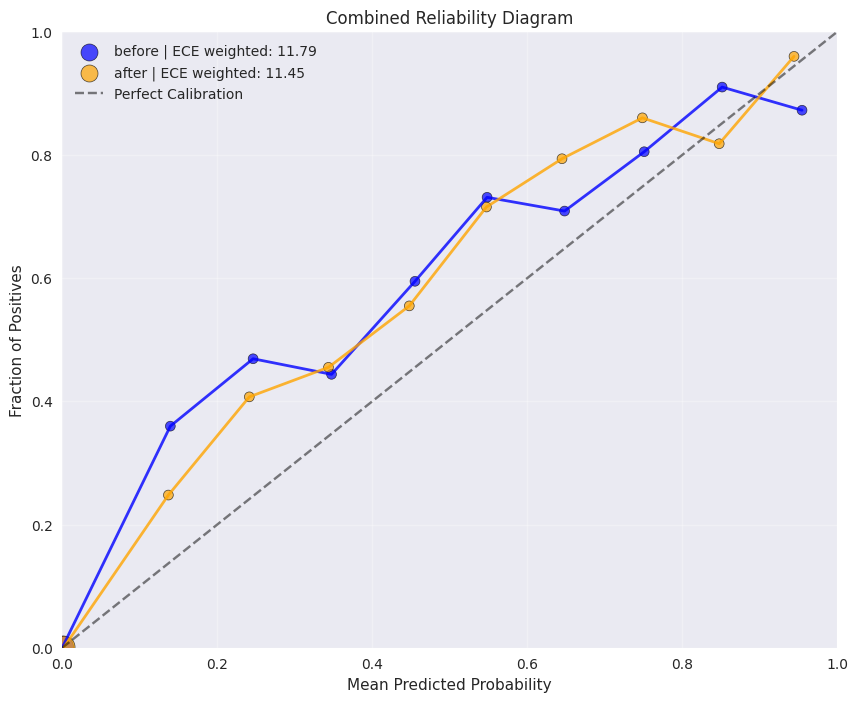

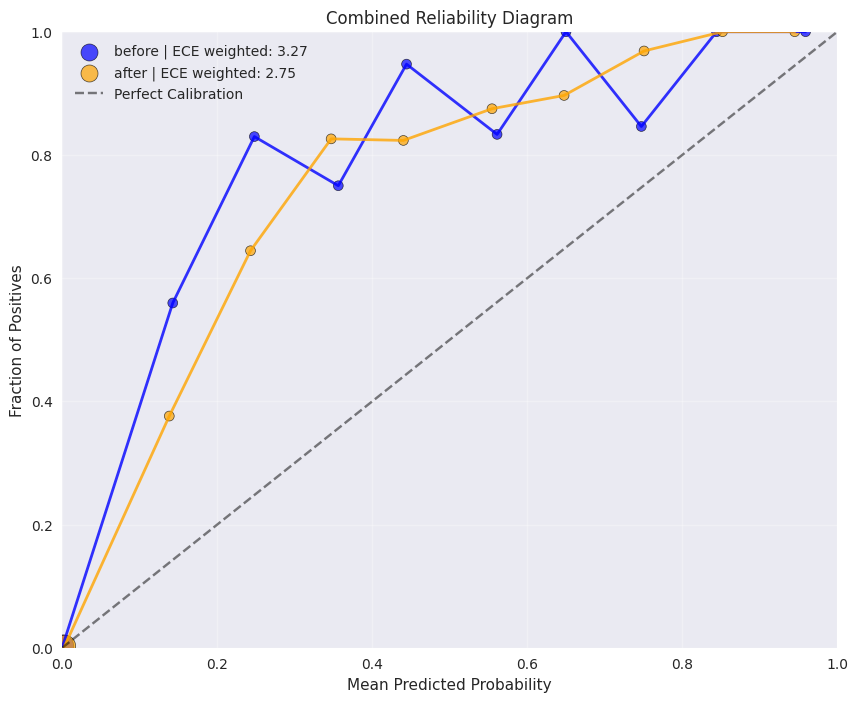

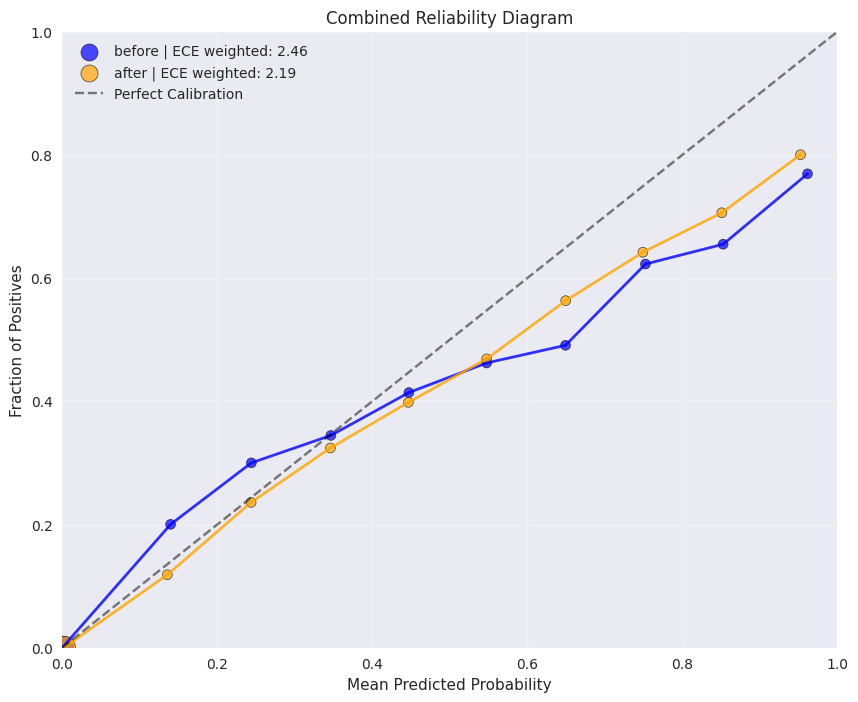

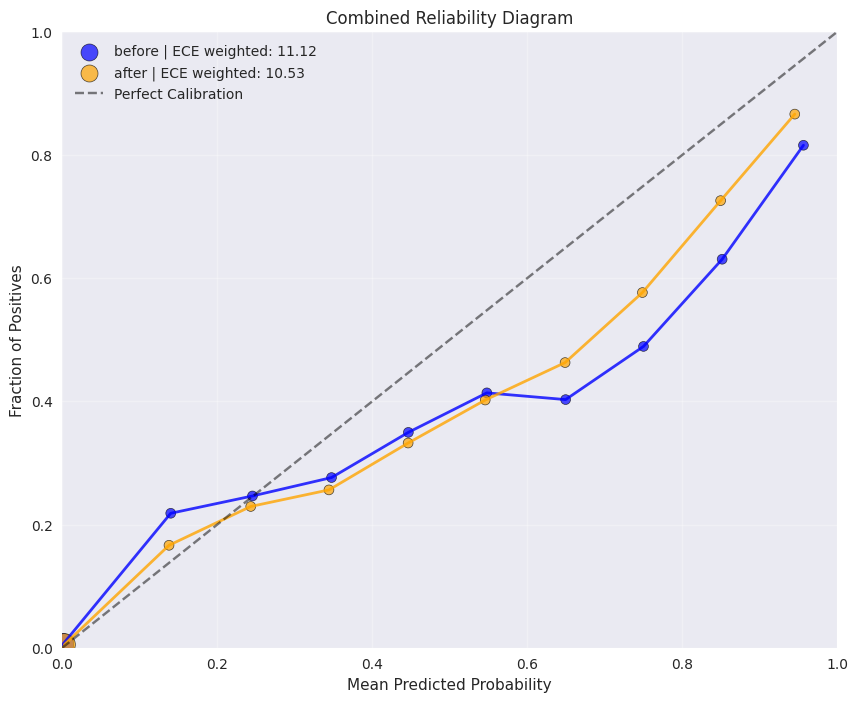

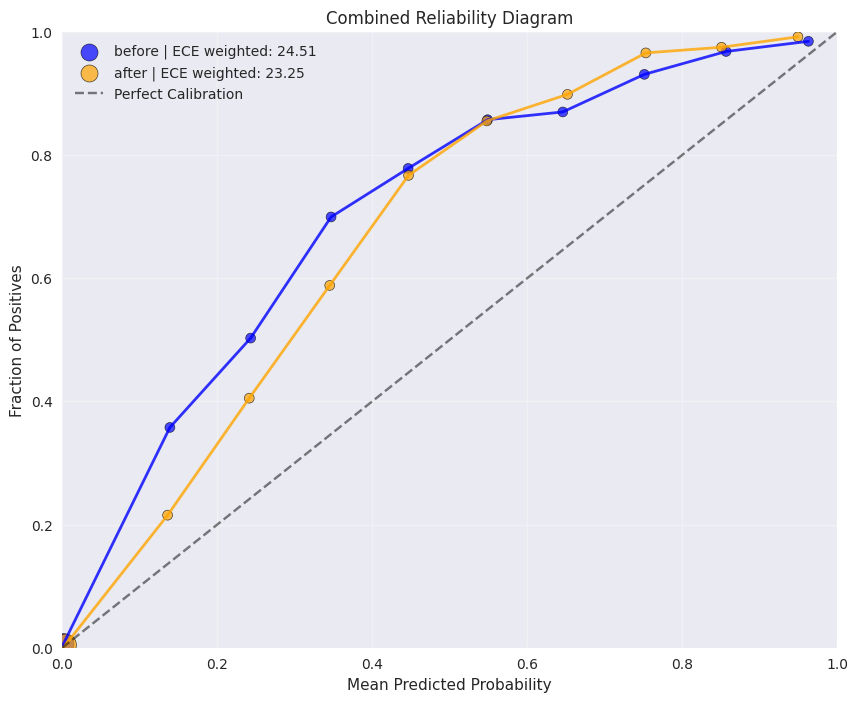

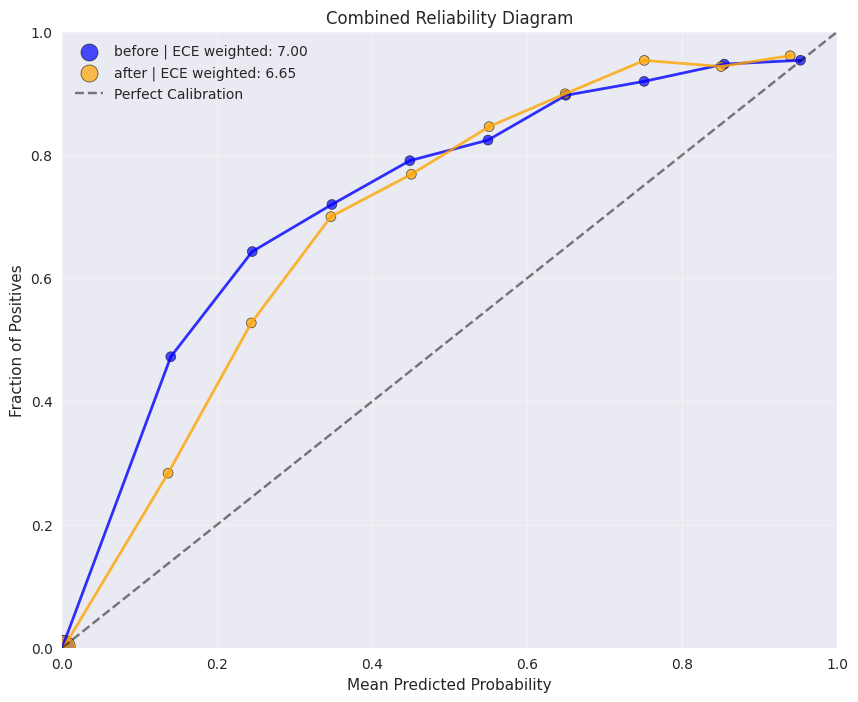

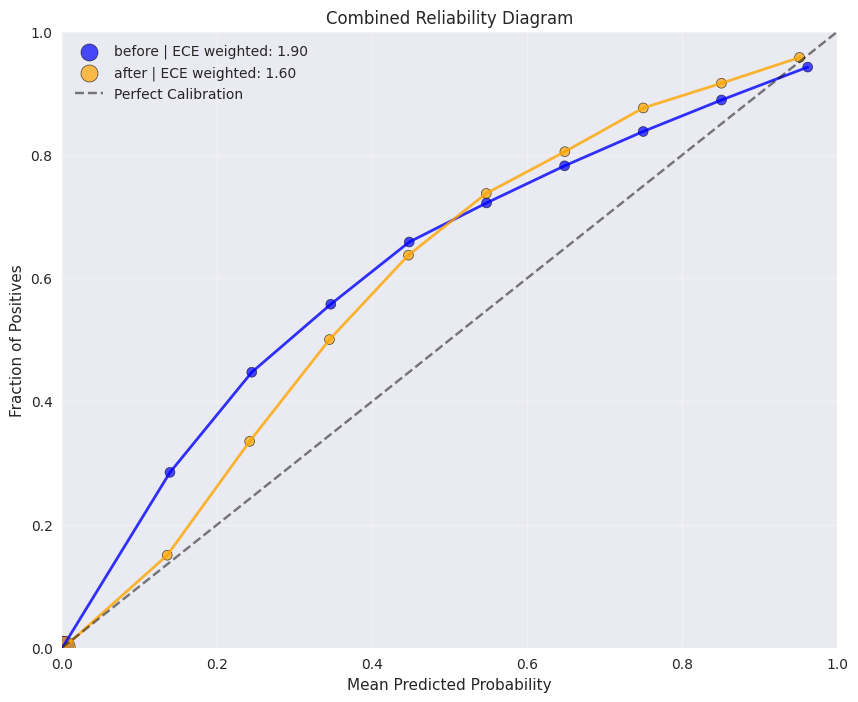

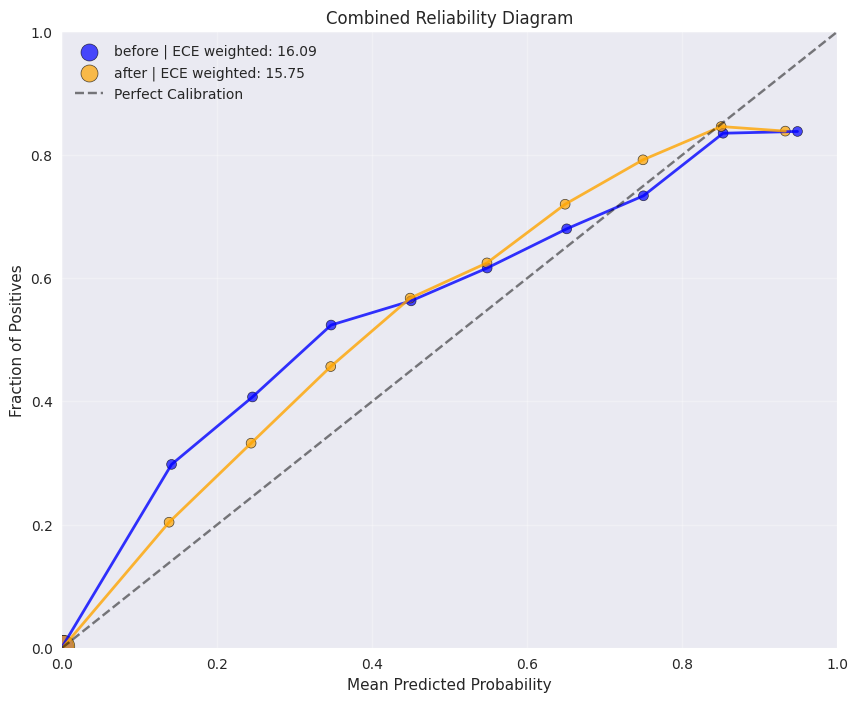

In [108]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    data_POW[dataset_name]["metrics"] = print_metrics(
        data_POW[dataset_name]["predictions"], data_POW[dataset_name]["targets"]
    )
    data_POW[dataset_name]["metrics_ts"] = print_metrics(
        data_POW[dataset_name]["predictions_ts"], data_POW[dataset_name]["targets"]
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data_POW[dataset_name]["predictions"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "blue",
            "metrics": data_POW[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data_POW[dataset_name]["predictions_ts"],
            "targets": data_POW[dataset_name]["targets"],
            "color": "orange",
            "metrics": data_POW[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
    )

# Temperature scaling using a porton of the test data

## Global temperature scaling: single temperature for all classes

In [51]:
from uncertainbird.utils.misc import split_test_set

data = split_test_set(data, split_ratio=0.1)

In [46]:
# Global temperature scaling using the HSN calibration split
from uncertainbird.utils.temperature_scaling import _fit_global_temperature, _apply_temperature_scaling


for dataset_name in valid_keys:

        print('_fit_global_temperature to', dataset_name)
        data[dataset_name]['global_temperature'] = _fit_global_temperature(
            data[dataset_name+'_cal']['predictions'],
            data[dataset_name+'_cal']['targets'],
        )
        print(f"Learned global temperature ({dataset_name}): {data[dataset_name+'_cal']['global_temperature']:.4f}"

        print('_apply_temperature_scaling to', dataset_name, "with temperature", data[dataset_name+'_cal']['global_temperature'])
        data[dataset_name+'_test']['predictions_ts'] = _apply_temperature_scaling(data[dataset_name+'_test']['predictions'], data[dataset_name+'_cal']['global_temperature'])

_fit_global_temperature to HSN
Learned global temperature (HSN): 1.2439
_fit_global_temperature to NBP
Learned global temperature (NBP): 1.3127
_fit_global_temperature to NES
Learned global temperature (NES): 1.1333
_fit_global_temperature to PER
Learned global temperature (PER): 1.6183
_fit_global_temperature to POW
Learned global temperature (POW): 1.4434
_fit_global_temperature to SNE
Learned global temperature (SNE): 1.3224
_fit_global_temperature to UHH
Learned global temperature (UHH): 1.4894
_apply_temperature_scaling to HSN with temperature 1.2439419031143188
_apply_temperature_scaling to NBP with temperature 1.3127081394195557
_apply_temperature_scaling to NES with temperature 1.1333203315734863
_apply_temperature_scaling to PER with temperature 1.618348479270935
_apply_temperature_scaling to POW with temperature 1.4434442520141602
_apply_temperature_scaling to SNE with temperature 1.32244873046875
_apply_temperature_scaling to UHH with temperature 1.489446759223938


/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Accuracy: tensor(0.9987)
cmAP: tensor(0.0269)
Precision: tensor(0.0320)
Recall: tensor(0.0049)
F1 Score: tensor(0.0079)
AUROC: tensor(0.0489)
ECE: tensor(0.0016)
ECE Weighted: tensor(0.1173)
ECE Top-3: tensor(0.1167)
ECE Top-5: tensor(0.0850)
ECE Top-10: tensor(0.0471)
ECE Top-21: tensor(0.0228)
Accuracy: tensor(0.9987)
cmAP: tensor(0.0269)
Precision: tensor(0.0320)
Recall: tensor(0.0049)
F1 Score: tensor(0.0079)
AUROC: tensor(0.0489)
ECE: tensor(0.0024)
ECE Weighted: tensor(0.1156)
ECE Top-3: tensor(0.1151)
ECE Top-5: tensor(0.0835)
ECE Top-10: tensor(0.0458)
ECE Top-21: tensor(0.0227)
Accuracy: tensor(0.9961)
cmAP: tensor(0.0800)
Precision: tensor(0.0820)
Recall: tensor(0.0210)
F1 Score: tensor(0.0302)
AUROC: tensor(0.1203)
ECE: tensor(0.0038)
ECE Weighted: tensor(0.0332)
ECE Top-3: tensor(0.0578)
ECE Top-5: tensor(0.0561)
ECE Top-10: tensor(0.0479)
ECE Top-21: tensor(0.0416)
Accuracy: tensor(0.9961)
cmAP: tensor(0.0800)
Precision: tensor(0.0820)
Recall: tensor(0.0210)
F1 Score: tens

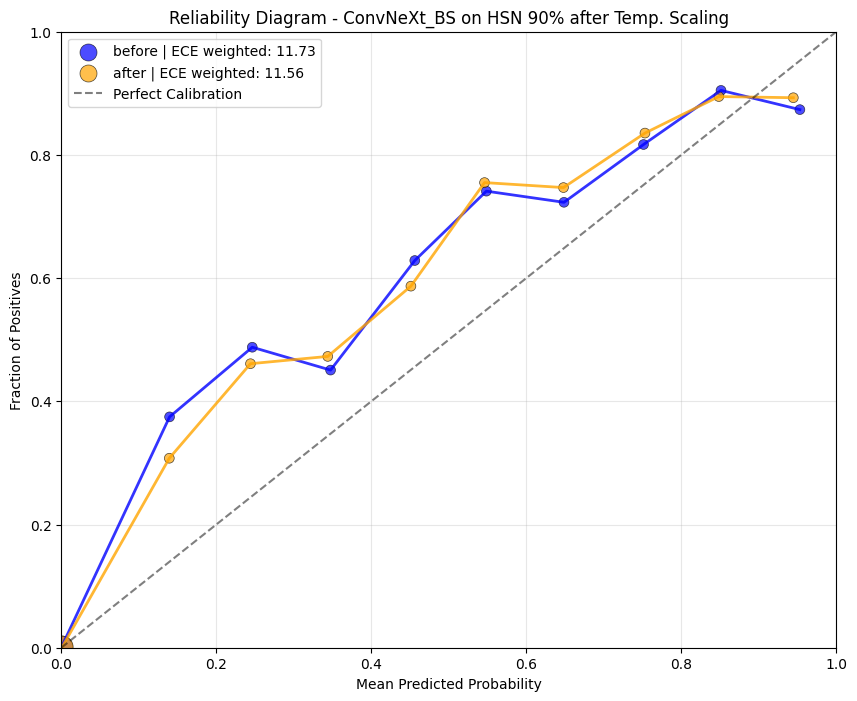

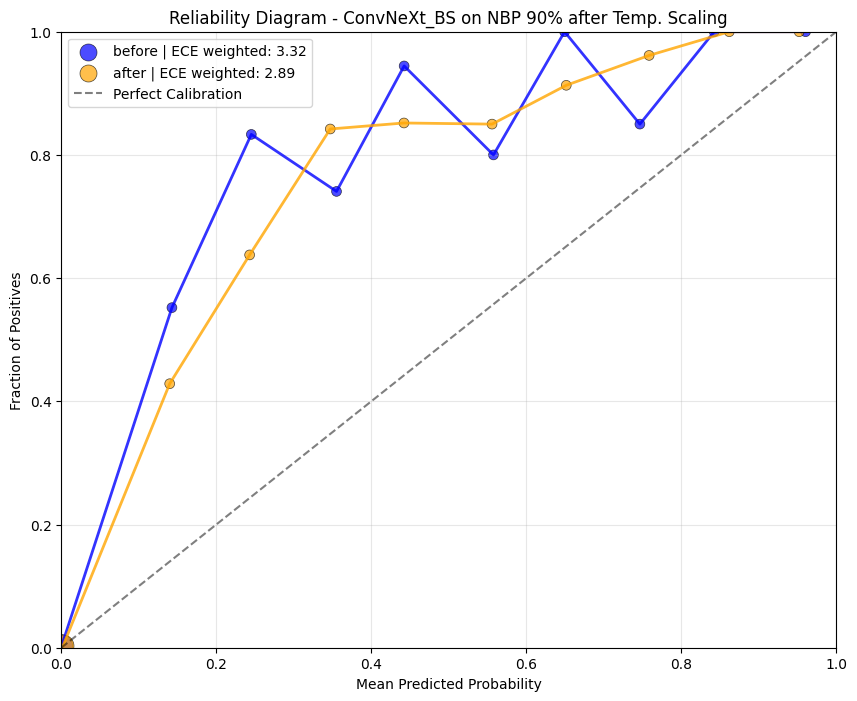

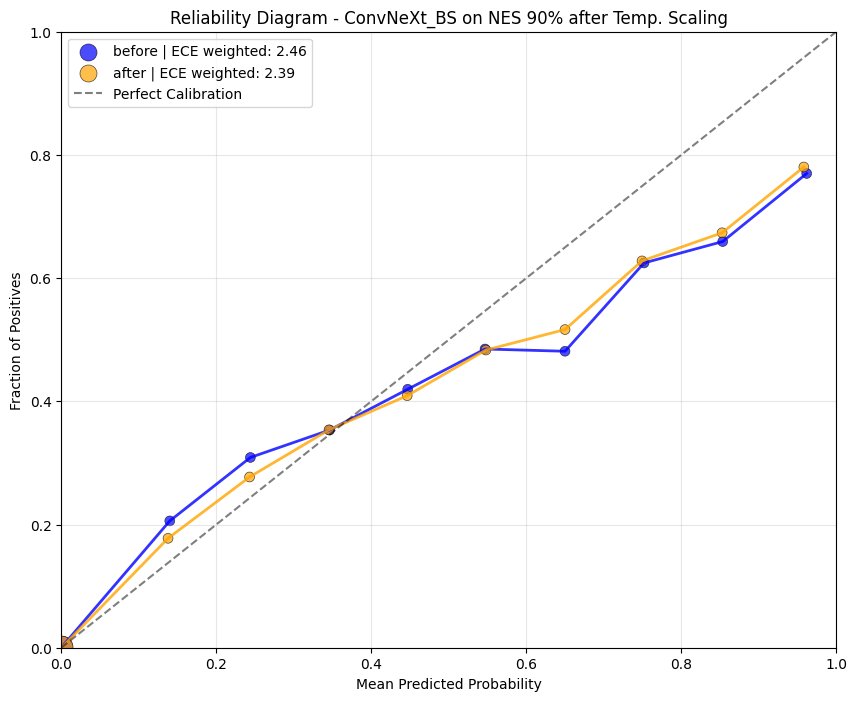

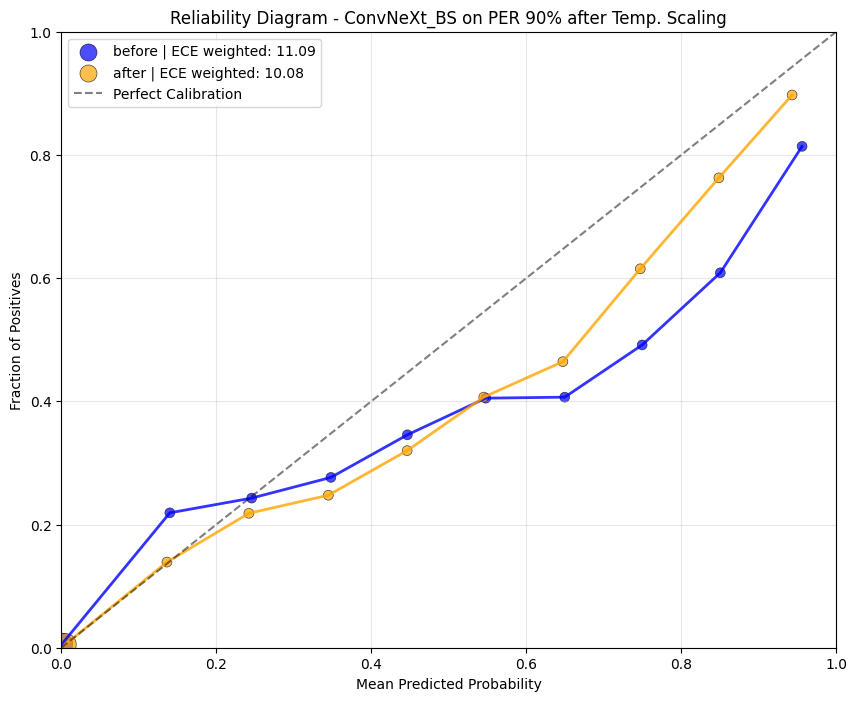

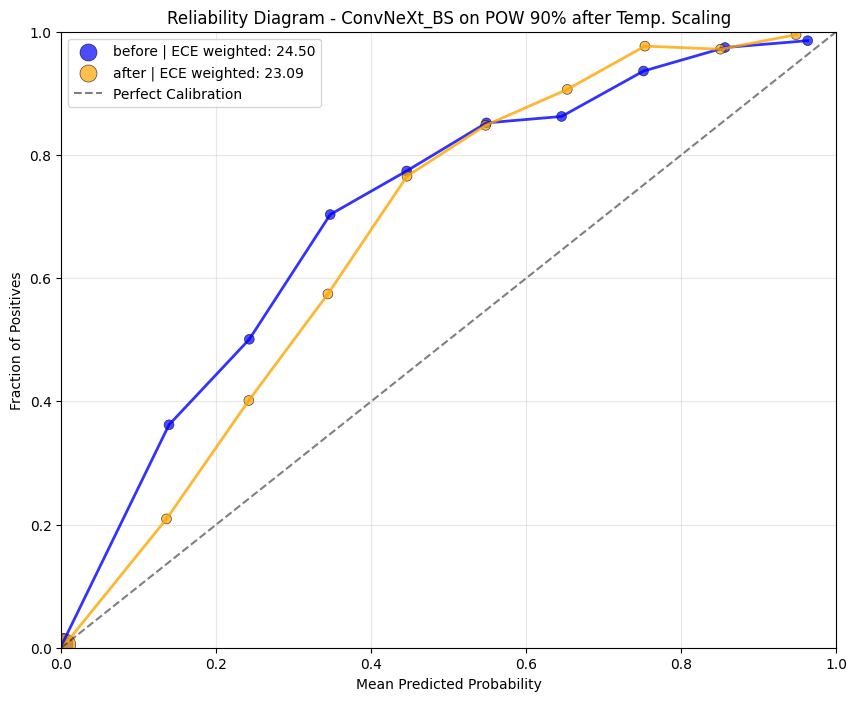

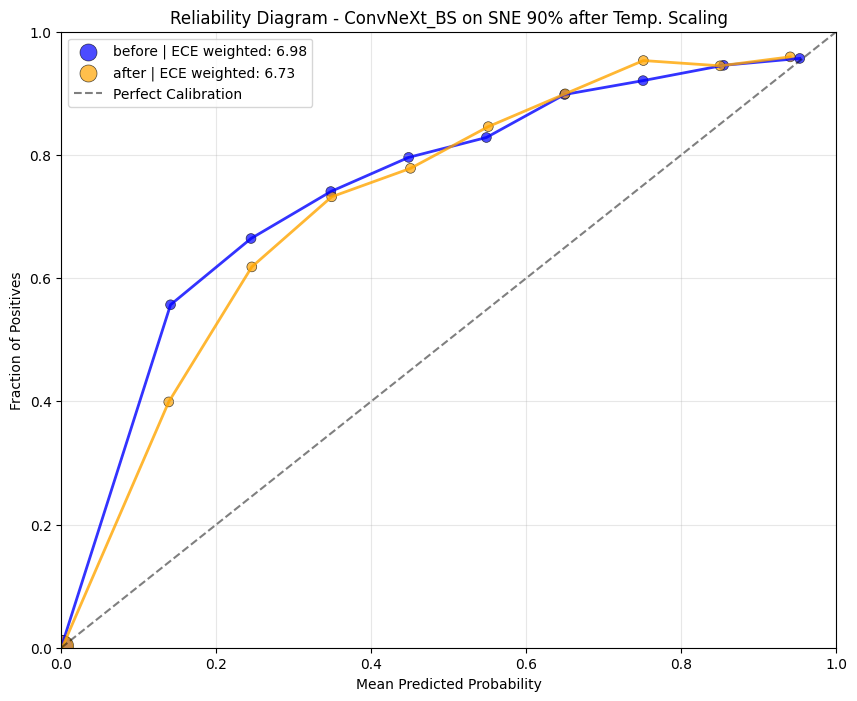

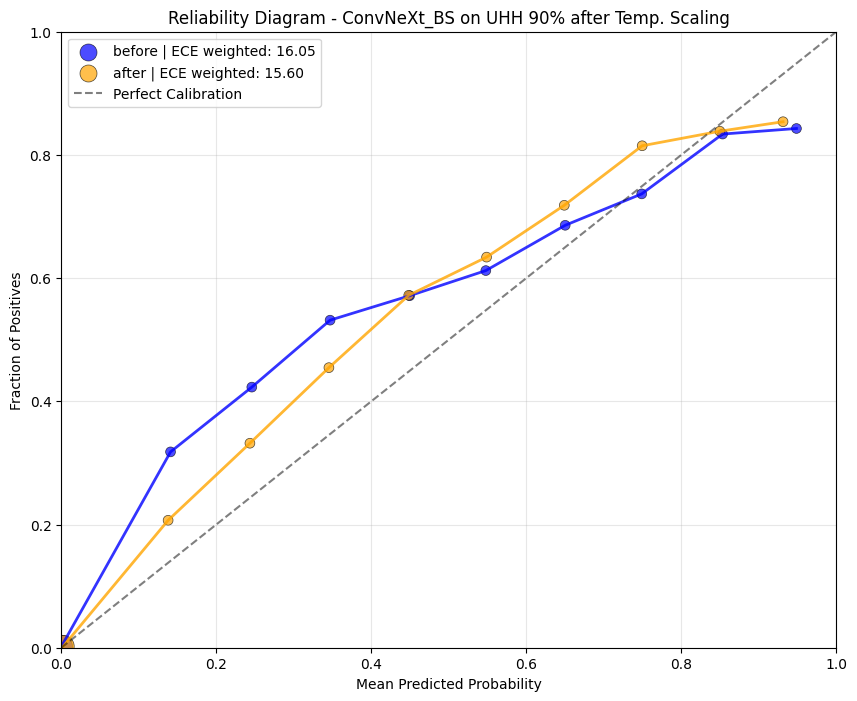

In [48]:
# compute metrics for HSN_test after temperature scaling
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    data[dataset_name]["metrics"] = print_metrics(
        data[dataset_name + "_test"]["predictions"],
        data[dataset_name + "_test"]["targets"],
    )
    data[dataset_name]["metrics_ts"] = print_metrics(
        data[dataset_name + "_test"]["predictions_ts"],
        data[dataset_name + "_test"]["targets"],
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data[dataset_name + "_test"]["predictions_ts"],
            "targets": data[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {dataset_name} 90% after Temp. Scaling",
    )

## Per class

In [52]:
# Global temperature scaling using the HSN calibration split
from uncertainbird.utils.temperature_scaling import (
    _fit_per_class_temperatures,
    _apply_temperature_scaling,
)

for dataset_name in valid_keys:

    print("_fit_per_class_temperatures to", dataset_name)
    data[dataset_name + "_cal"]["temperatures"] = _fit_per_class_temperatures(
        data[dataset_name + "_cal"]["predictions"],
        data[dataset_name + "_cal"]["targets"],
    )

for dataset_name in valid_keys:

    print("_apply_temperature_scaling to", dataset_name)
    data[dataset_name + "_test"]["predictions_ts"] = _apply_temperature_scaling(
        data[dataset_name + "_test"]["predictions"],
        data[dataset_name + "_cal"]["temperatures"],
    )

_fit_per_class_temperatures to HSN
_fit_per_class_temperatures to NBP
_fit_per_class_temperatures to NES
_fit_per_class_temperatures to PER
_fit_per_class_temperatures to POW
_fit_per_class_temperatures to SNE
_fit_per_class_temperatures to SSW
_fit_per_class_temperatures to UHH
_apply_temperature_scaling to HSN with temperatures tensor([0.5368, 0.5655, 0.5568, 0.5624, 0.5598, 0.6008, 0.6219, 0.5354, 0.5572,
        0.5729, 0.5318, 0.4602, 0.5617, 0.5465, 0.5601, 0.5955, 0.5400, 0.5080,
        0.5891, 0.5498, 0.6104, 0.5348, 0.5744, 0.6174, 0.5491, 0.5395, 0.2144,
        0.4817, 0.5807, 0.5247, 0.5395, 0.1947, 0.4823, 0.5104, 0.5279, 0.5702,
        0.4701, 0.5511, 0.5511, 0.5301, 0.5455, 0.5285, 0.5014, 0.5566, 0.5131,
        0.5178, 0.4983, 0.5117, 0.5838, 0.5293, 0.5310, 0.5570, 1.1559, 0.4247,
        0.5650, 0.5796, 0.6537, 0.5893, 0.4293, 0.5860, 0.5310, 0.4894, 0.5554,
        0.5545, 0.6182, 0.4987, 0.5856, 0.5414, 0.5299, 0.5712, 0.5128, 0.5531,
        0.5347, 0.6044, 0.54

/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples found in target, recall is undefined. Setting recall to one for all thresholds.
  warnings.warn(*args, **kwargs)
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Accuracy: tensor(0.9988)
cmAP: tensor(0.0251)
Precision: tensor(0.0298)
Recall: tensor(0.0046)
F1 Score: tensor(0.0073)
AUROC: tensor(0.0455)
ECE: tensor(0.0015)
ECE Weighted: tensor(0.1173)
ECE Top-3: tensor(0.1167)
ECE Top-5: tensor(0.0850)
ECE Top-10: tensor(0.0471)
ECE Top-21: tensor(0.0228)
Accuracy: tensor(0.9988)
cmAP: tensor(0.0251)
Precision: tensor(0.0298)
Recall: tensor(0.0046)
F1 Score: tensor(0.0073)
AUROC: tensor(0.0455)
ECE: tensor(0.0007)
ECE Weighted: tensor(0.0727)
ECE Top-3: tensor(0.0778)
ECE Top-5: tensor(0.0529)
ECE Top-10: tensor(0.0284)
ECE Top-21: tensor(0.0138)
Accuracy: tensor(0.9964)
cmAP: tensor(0.0745)
Precision: tensor(0.0764)
Recall: tensor(0.0195)
F1 Score: tensor(0.0281)
AUROC: tensor(0.1121)
ECE: tensor(0.0035)
ECE Weighted: tensor(0.0332)
ECE Top-3: tensor(0.0578)
ECE Top-5: tensor(0.0561)
ECE Top-10: tensor(0.0478)
ECE Top-21: tensor(0.0416)
Accuracy: tensor(0.9964)
cmAP: tensor(0.0740)
Precision: tensor(0.0764)
Recall: tensor(0.0195)
F1 Score: tens

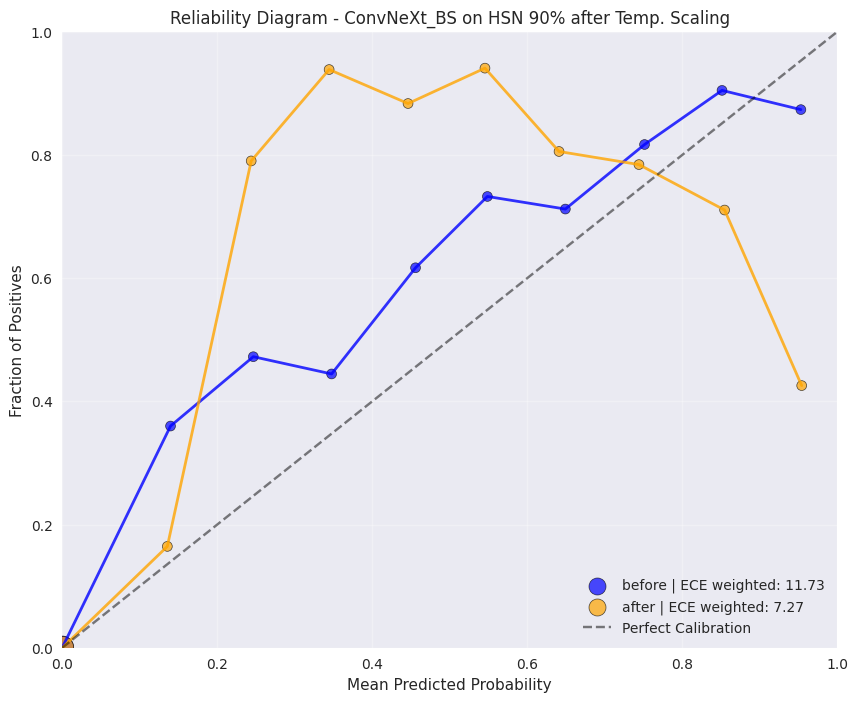

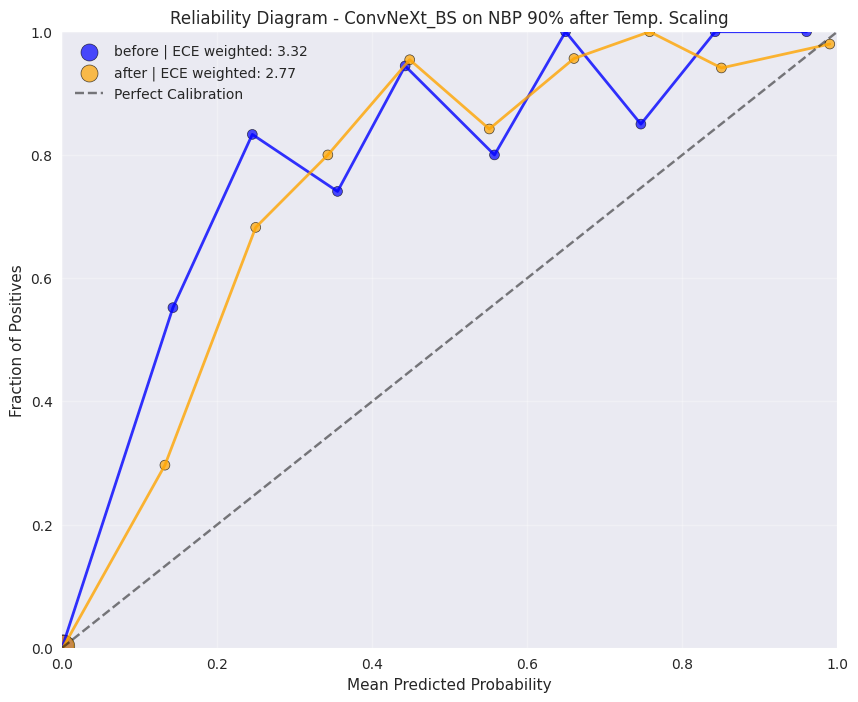

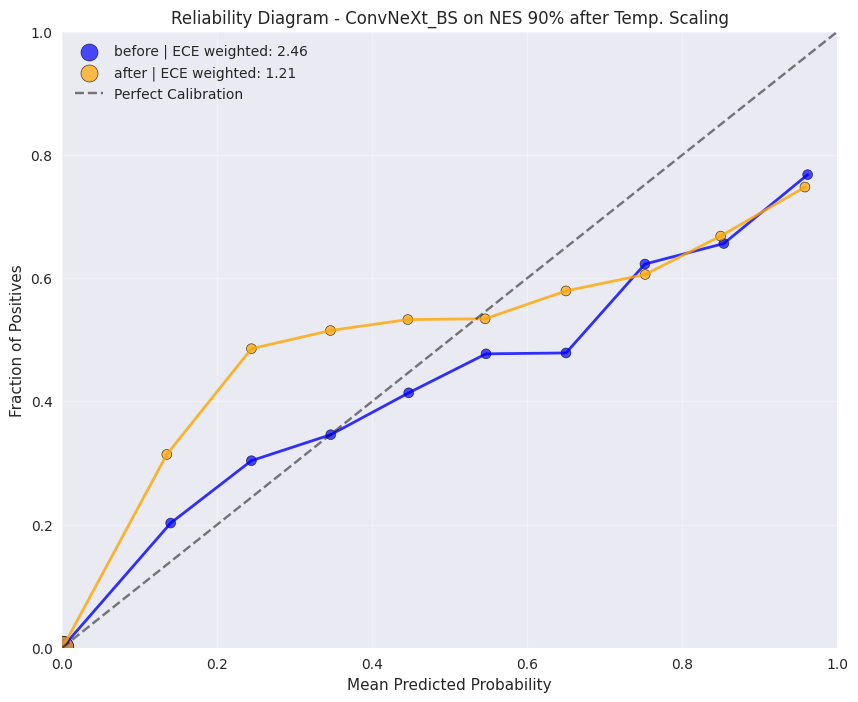

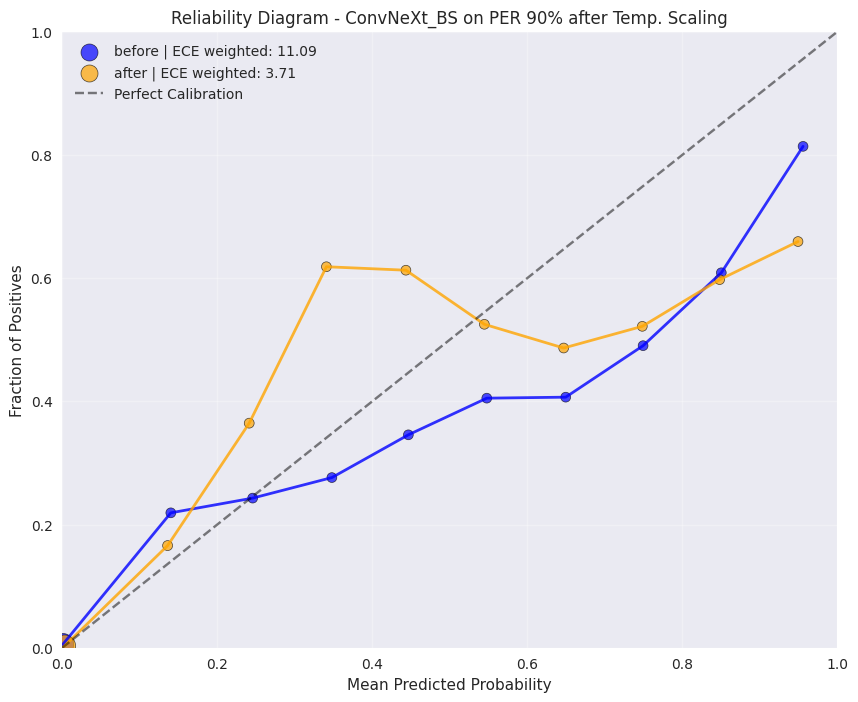

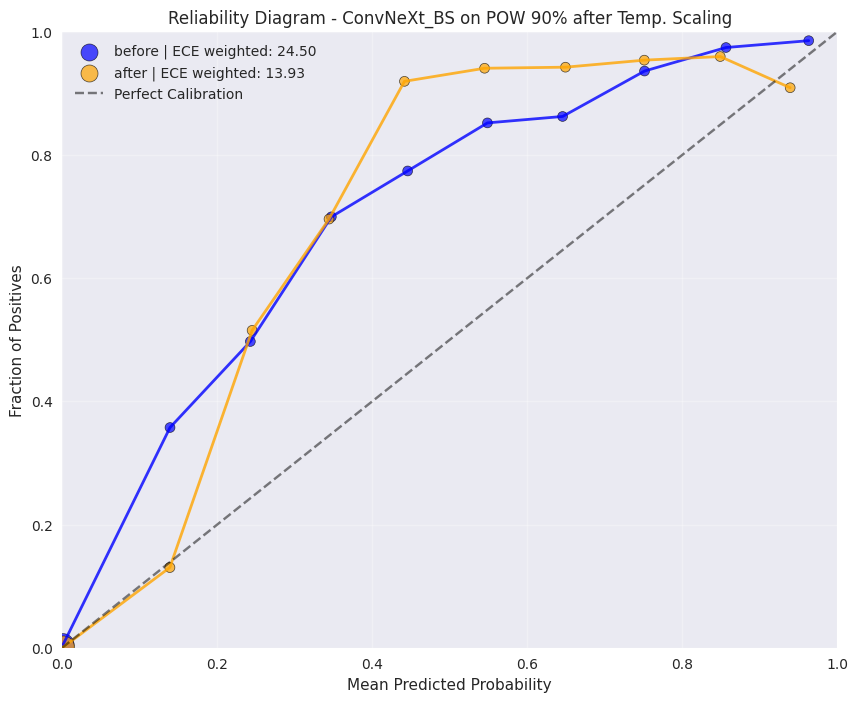

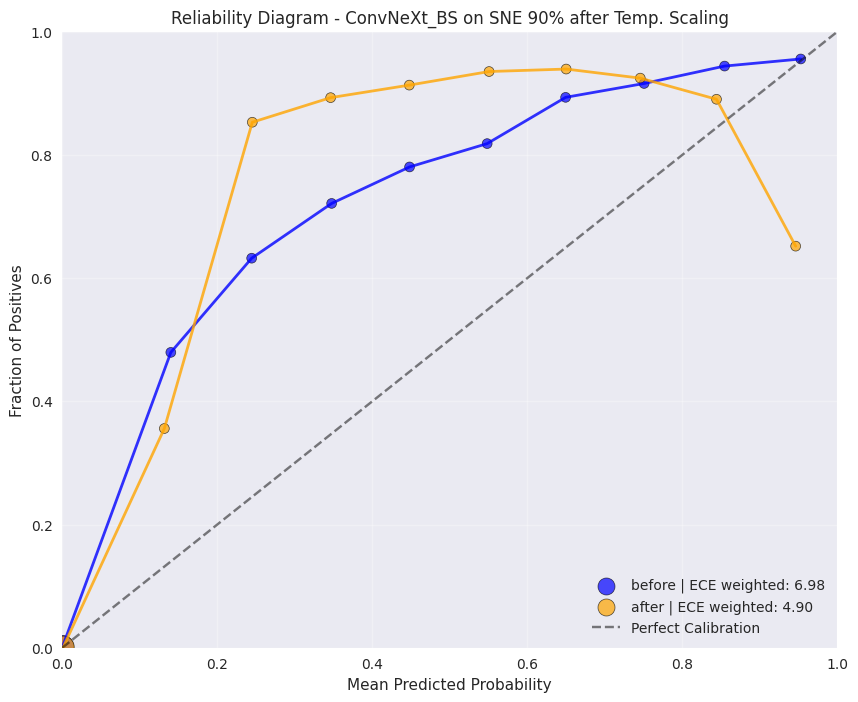

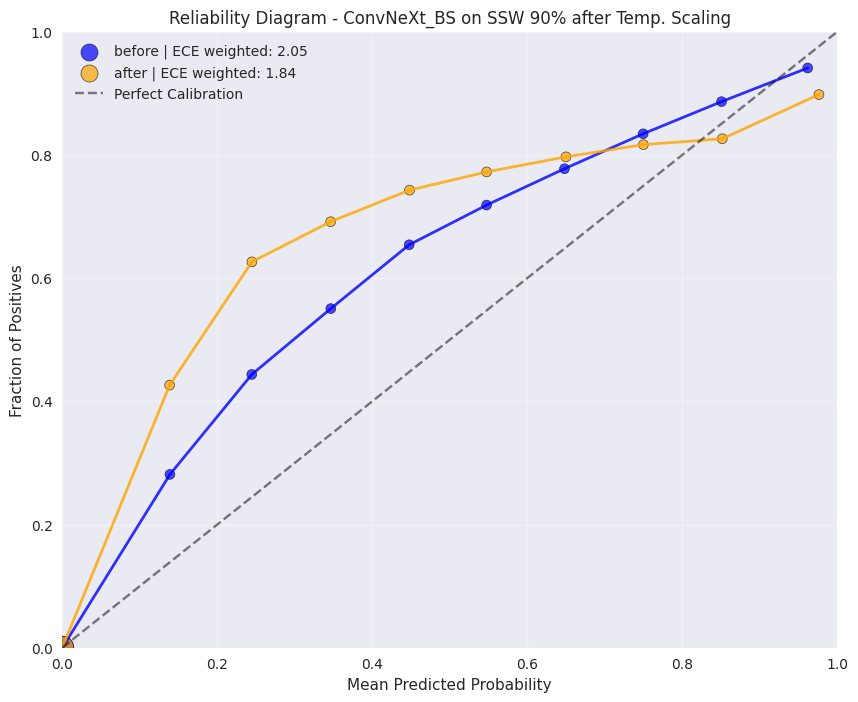

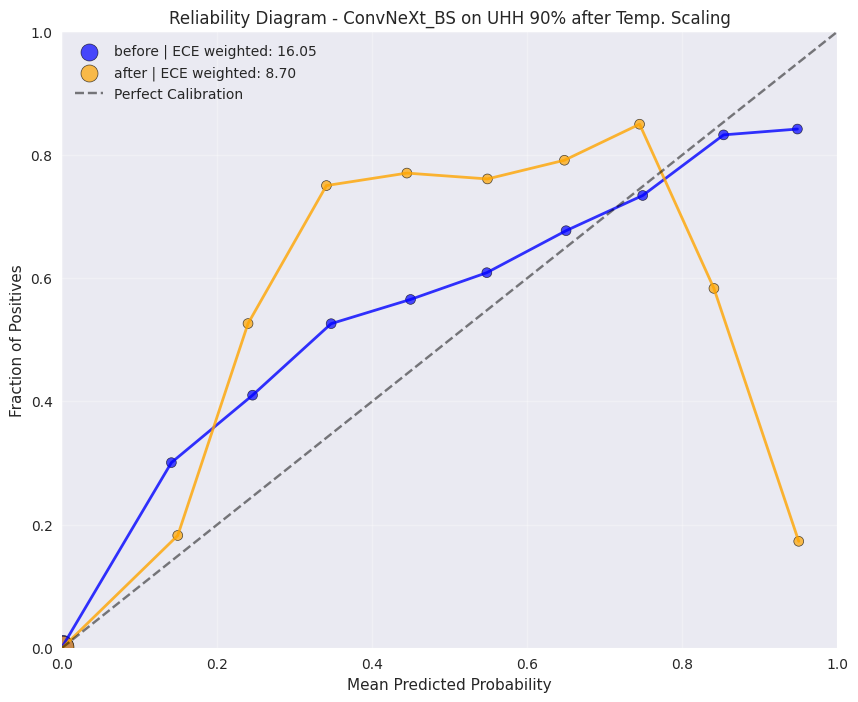

In [55]:
from uncertainbird.utils.plotting import (
    plot_combined_reliability_diagram,
    print_metrics,
)


for dataset_name in valid_keys:
    data[dataset_name]["metrics"] = print_metrics(
        data[dataset_name + "_test"]["predictions"],
        data[dataset_name + "_test"]["targets"],
    )
    data[dataset_name]["metrics_ts"] = print_metrics(
        data[dataset_name + "_test"]["predictions_ts"],
        data[dataset_name + "_test"]["targets"],
    )
    # reliability diagram after temperature scaling including before and after
    combined_data = {
        "before": {
            "predictions": data[dataset_name + "_test"]["predictions"],
            "targets": data[dataset_name + "_test"]["targets"],
            "color": "blue",
            "metrics": data[dataset_name]["metrics"],
        },
        "after": {
            "predictions": data[dataset_name + "_test"]["predictions_ts"],
            "targets": data[dataset_name + "_test"]["targets"],
            "color": "orange",
            "metrics": data[dataset_name]["metrics_ts"],
        },
    }
    plot_combined_reliability_diagram(
        combined_data,
        n_bins=10,
        title=f"Reliability Diagram - ConvNeXt_BS on {dataset_name} 90% after Temp. Scaling",
    )

## Ablation: how much data is needed for temperature scaling?

Compute ECE after temperature scaling for each dataset and for [0.01, 0.02, 0.05, 0.1, 0.2, 0.3] fraction of the calibration data



In [79]:
split_ratios = [0.01, 0.02, 0.05, 0.1, 0.15, 0.2]
# save ece scores for each split ratio and dataset
metrics = {
    split_ratio: {dataset_name: None for dataset_name in valid_keys}
    for split_ratio in split_ratios
}

for split_ratio in split_ratios:
    print("Using calibration split ratio:", split_ratio)
    data_splitted = split_test_set(data, split_ratio=split_ratio)
    # for each dataset compute per-class temperature scaling on the calibration split and apply it to the test split
    for dataset_name in valid_keys:
        print("_fit_per_class_temperatures to", dataset_name)
        data_splitted[dataset_name + "_cal"]["temperatures"] = (
            _fit_per_class_temperatures(
                data_splitted[dataset_name + "_cal"]["predictions"],
                data_splitted[dataset_name + "_cal"]["targets"],
            )
        )
        data_splitted[dataset_name + "_test"]["predictions_ts"] = (
            _apply_temperature_scaling(
                data_splitted[dataset_name + "_test"]["predictions"],
                data_splitted[dataset_name + "_cal"]["temperatures"],
            )
        )
        # compute metrics
        data_splitted[dataset_name]["metrics_ts"] = print_metrics(
            data_splitted[dataset_name + "_test"]["predictions_ts"],
            data_splitted[dataset_name + "_test"]["targets"],
        )
        metrics[split_ratio][dataset_name] = data_splitted[dataset_name]["metrics_ts"]

Using calibration split ratio: 0.01
_fit_per_class_temperatures to HSN


/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Accuracy: tensor(0.9988)
cmAP: tensor(0.4905)
Precision: tensor(0.0298)
Recall: tensor(0.0044)
F1 Score: tensor(0.0070)
AUROC: tensor(0.0454)
ECE: tensor(0.0010)
ECE Weighted: tensor(0.0928)
ECE Top-3: tensor(0.0991)
ECE Top-5: tensor(0.0685)
ECE Top-10: tensor(0.0381)
ECE Top-21: tensor(0.0185)
_fit_per_class_temperatures to NBP
Accuracy: tensor(0.9964)
cmAP: tensor(0.6051)
Precision: tensor(0.0761)
Recall: tensor(0.0207)
F1 Score: tensor(0.0294)
AUROC: tensor(0.1127)
ECE: tensor(0.0047)
ECE Weighted: tensor(0.0438)
ECE Top-3: tensor(0.0596)
ECE Top-5: tensor(0.0549)
ECE Top-10: tensor(0.0567)
ECE Top-21: tensor(0.0549)
_fit_per_class_temperatures to NES
Accuracy: tensor(0.9989)
cmAP: tensor(0.3441)
Precision: tensor(0.0941)
Recall: tensor(0.0324)
F1 Score: tensor(0.0420)
AUROC: tensor(0.1897)
ECE: tensor(0.0009)
ECE Weighted: tensor(0.0161)
ECE Top-3: tensor(0.0297)
ECE Top-5: tensor(0.0230)
ECE Top-10: tensor(0.0159)
ECE Top-21: tensor(0.0106)
_fit_per_class_temperatures to PER
Accu

In [85]:
metrics[0.1]["HSN"].keys()

dict_keys(['accuracy', 'cmAP', 'precision', 'recall', 'f1_score', 'auroc', 'ece', 'ece_weighted', 'ece_top_3', 'ece_top_5', 'ece_top_10', 'ece_top_21'])

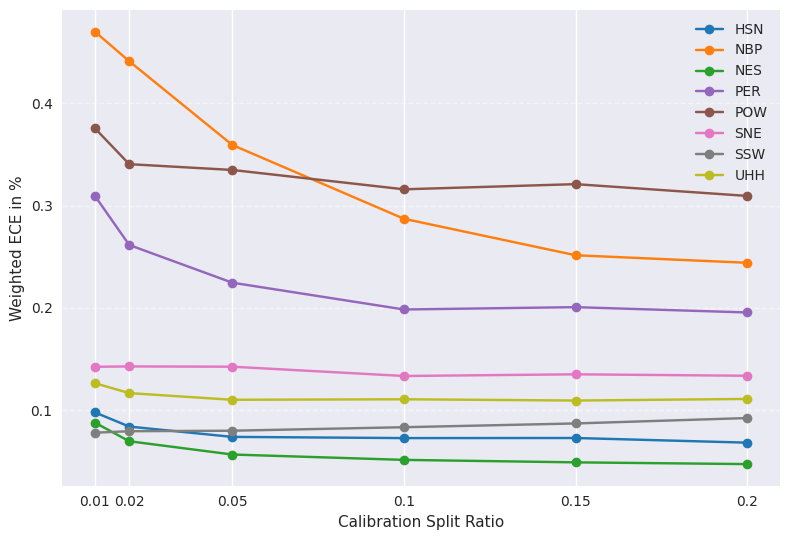

In [91]:
# plot ece scores vs split ratio for each dataset
for dataset_name in valid_keys:
    plt.plot(
        split_ratios,
        [
            metrics[split_ratio][dataset_name]["ece"] * 100
            for split_ratio in split_ratios
        ],
        marker="o",
        color=data[dataset_name]["color"],
        label=dataset_name,
    )
plt.xlabel("Calibration Split Ratio")
plt.ylabel("Weighted ECE in %")
# log scale y axis

plt.xticks(split_ratios, split_ratios)  # only show actual sampled values
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

### Ablation: How many samples per class are needed to improve calibration

In [92]:
from uncertainbird.utils.misc import split_based_on_x_samples_per_class


samples_per_class = [1, 2, 5, 10, 15, 20]
# save ece scores for each split ratio and dataset
metrics = {
    samples_per: {dataset_name: None for dataset_name in valid_keys}
    for samples_per in samples_per_class
}

for samples_per in samples_per_class:
    print("Using ", samples_per, "sample per class for calibration")
    data_splitted = split_based_on_x_samples_per_class(data, samples_per)
    # for each dataset compute per-class temperature scaling on the calibration split and apply it to the test split
    for dataset_name in valid_keys:
        print("_fit_per_class_temperatures to", dataset_name)
        data_splitted[dataset_name + "_cal"]["temperatures"] = (
            _fit_per_class_temperatures(
                data_splitted[dataset_name + "_cal"]["predictions"],
                data_splitted[dataset_name + "_cal"]["targets"],
            )
        )
        data_splitted[dataset_name + "_test"]["predictions_ts"] = (
            _apply_temperature_scaling(
                data_splitted[dataset_name + "_test"]["predictions"],
                data_splitted[dataset_name + "_cal"]["temperatures"],
            )
        )
        # compute metrics
        data_splitted[dataset_name]["metrics_ts"] = print_metrics(
            data_splitted[dataset_name + "_test"]["predictions_ts"],
            data_splitted[dataset_name + "_test"]["targets"],
        )
        metrics[samples_per][dataset_name] = data_splitted[dataset_name]["metrics_ts"]

Using  1 sample per class for calibration
_fit_per_class_temperatures to HSN


/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Average precision score for one or more classes was `nan`. Ignoring these classes in macro-average
  warnings.warn(*args, **kwargs)
/home/vscode/.cache/pypoetry/virtualenvs/birdset-xS3fZVNL-py3.10/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)


Accuracy: tensor(0.9988)
cmAP: tensor(0.5400)
Precision: tensor(0.0299)
Recall: tensor(0.0046)
F1 Score: tensor(0.0073)
AUROC: tensor(0.0412)
ECE: tensor(0.0020)
ECE Weighted: tensor(0.0724)
ECE Top-3: tensor(0.0666)
ECE Top-5: tensor(0.0612)
ECE Top-10: tensor(0.0465)
ECE Top-21: tensor(0.0343)
_fit_per_class_temperatures to NBP
Accuracy: tensor(0.9964)
cmAP: tensor(0.5954)
Precision: tensor(0.0766)
Recall: tensor(0.0195)
F1 Score: tensor(0.0281)
AUROC: tensor(0.1119)
ECE: tensor(0.0026)
ECE Weighted: tensor(0.0255)
ECE Top-3: tensor(0.0398)
ECE Top-5: tensor(0.0329)
ECE Top-10: tensor(0.0363)
ECE Top-21: tensor(0.0300)
_fit_per_class_temperatures to NES
Accuracy: tensor(0.9989)
cmAP: tensor(0.3492)
Precision: tensor(0.0936)
Recall: tensor(0.0332)
F1 Score: tensor(0.0424)
AUROC: tensor(0.1850)
ECE: tensor(0.0020)
ECE Weighted: tensor(0.0275)
ECE Top-3: tensor(0.0513)
ECE Top-5: tensor(0.0367)
ECE Top-10: tensor(0.0241)
ECE Top-21: tensor(0.0158)
_fit_per_class_temperatures to PER
Accu

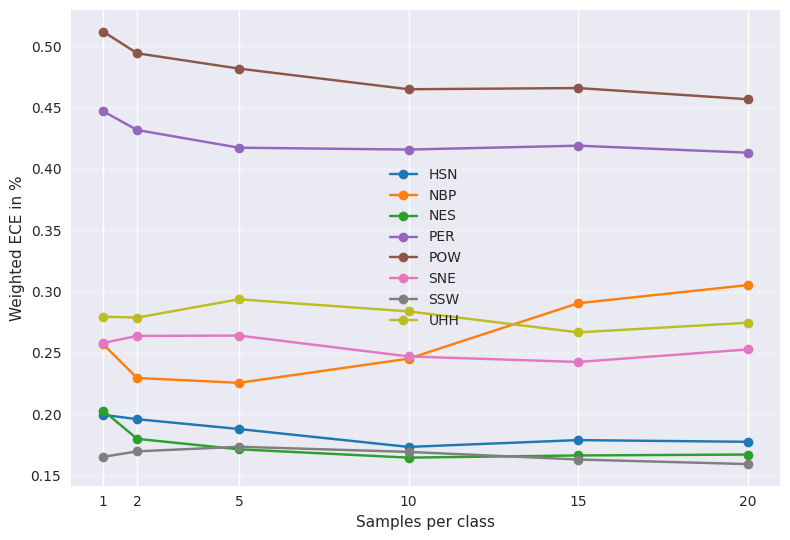

In [97]:
# plot ece scores vs number of samples per class for each dataset
for dataset_name in valid_keys:
    plt.plot(
        samples_per_class,
        [metrics[s][dataset_name]["ece"].item() * 100 for s in samples_per_class],
        marker="o",
        color=data[dataset_name]["color"],
        label=dataset_name,
    )

plt.xlabel("Samples per class")
plt.ylabel("Weighted ECE in %")
plt.xticks(samples_per_class, samples_per_class)  # only show actual sampled values
plt.legend()
plt.grid(True, axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()